In [20]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.svm import SVC
import numpy as np
import pywt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_config

In [21]:
df_train = pd.read_csv('./data/fashion-mnist_train.csv')
df_test = pd.read_csv('./data/fashion-mnist_test.csv')

In [22]:
label_train = df_train['label']
data_train = df_train.drop('label', axis=1) / 255
data_test = df_test.drop('label', axis=1) / 255
label_test = df_test['label']

In [23]:
data_train = data_train[:len(data_train)]
data_test = data_test[:len(data_test)]
label_train = label_train[:len(label_train)]
label_test = label_test[:len(label_test)]

In [24]:
def extract_wavelet_features(data):
    features = []
    for i in range(len(data)):
        # Reshape la ligne complète (784 pixels) en image 28x28
        image = data.iloc[i].values.reshape(28, 28)

        # Applique la transformation wavelet
        LL, (LH, HL, HH) = pywt.dwt2(image, 'bior1.3')

        # Concatène les coefficients en 1D
        feature = np.concatenate([LL.ravel(), LH.ravel(), HL.ravel(), HH.ravel()])
        features.append(feature)

    return np.array(features)

# Utilisation
features = extract_wavelet_features(data_train)
features_test = extract_wavelet_features(data_test)

In [25]:
model_1 = XGBClassifier(
    max_depth=5,
    n_estimators=500,
    random_state=42,
    tree_method='hist',
    n_jobs=-1,
    verbosity=2
)

In [7]:
model_2 = SVC(
    C=0.1,
    kernel='poly',
    cache_size=1000,
    verbose=True
)

In [26]:
model_3 = RandomForestClassifier(
    n_estimators=250,
    criterion='entropy',
    random_state=42,
    n_jobs=-1,  # paralléliser
    verbose=1
)

In [27]:
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', model_1),
        ('knn', model_2),
        ('rf', model_3)
    ],
    voting='hard',  # Vote majoritaire simple
    verbose=3
)

In [28]:
with parallel_config(verbose=10):
    voting_clf.fit(features, label_train)

[17:14:16] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (60000, 1024, 61440000).
[Voting] ................... (1 of 3) Processing logreg, total= 3.8min


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  3.6min


[LibSVM].
*
optimization finished, #iter = 1131
obj = -149.378336, rho = -0.776732
nSV = 2031, nBSV = 1989
.
*
optimization finished, #iter = 1658
obj = -257.127481, rho = -0.415173
nSV = 3032, nBSV = 2982
..
*
optimization finished, #iter = 2304
obj = -353.519364, rho = -0.017221
nSV = 4169, nBSV = 4108
.
*
optimization finished, #iter = 1244
obj = -168.735002, rho = -0.803699
nSV = 2119, nBSV = 2047
.
*.
*
optimization finished, #iter = 1233
obj = -160.922229, rho = 0.961327
nSV = 2128, nBSV = 2083
...
*
optimization finished, #iter = 3691
obj = -573.322143, rho = 0.103572
nSV = 6283, nBSV = 6182
*
optimization finished, #iter = 933
obj = -134.590319, rho = 0.388561
nSV = 1823, nBSV = 1812
.
*
optimization finished, #iter = 1175
obj = -170.118836, rho = -0.576072
nSV = 2132, nBSV = 2081
*
optimization finished, #iter = 522
obj = -60.427030, rho = -0.869297
nSV = 903, nBSV = 870
*
optimization finished, #iter = 958
obj = -122.083466, rho = 0.724335
nSV = 1686, nBSV = 1644
.
*.
*
optim

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.8s


[Voting] ....................... (3 of 3) Processing rf, total=  34.5s


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   33.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.9min finished


In [29]:
prediction = voting_clf.predict(features_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.1s finished


In [30]:
voting_clf.score(features_test, label_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.1s finished


0.9

In [31]:
matrice = confusion_matrix(label_test, prediction)

In [32]:
print(classification_report(label_test, prediction))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.84      0.85      0.85      1000
           3       0.90      0.94      0.92      1000
           4       0.87      0.87      0.87      1000
           5       0.96      0.95      0.96      1000
           6       0.78      0.68      0.72      1000
           7       0.92      0.94      0.93      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.95      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



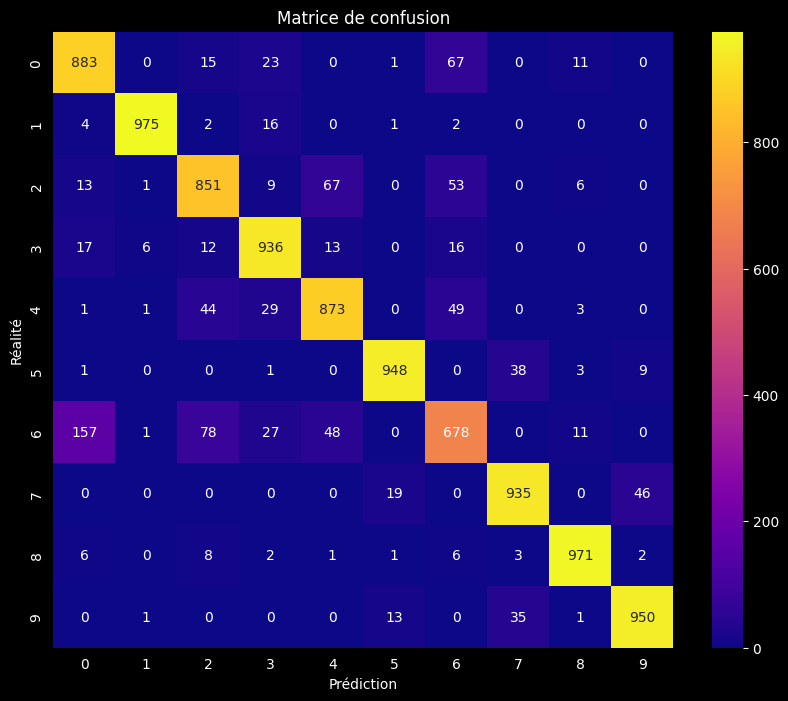

In [33]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrice, annot=True, fmt='d', cmap='plasma',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.show()

In [34]:
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', model_1),
        ('svc', model_2),
        ('rf', model_3)
    ],
    final_estimator=LogisticRegression(max_iter=1000),  # Le méta-modèle
    cv=5,  # Cross-validation pour générer les méta-features
    n_jobs=-1,
    verbose=2  # Celui-là affiche vraiment la progression
)

In [35]:
stacking_clf.fit(features, label_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[LibSVM]

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s


[17:26:00] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (60000, 1024, 61440000).
[17:26:03] INFO: /workspace/src/common/cuda_dr_utils.cc:179: Driver version: `591.59`
.
*
optimization finished, #iter = 1131
obj = -149.378336, rho = -0.776732
nSV = 2031, nBSV = 1989
.
*
optimization finished, #iter = 1658
obj = -257.127481, rho = -0.415173
nSV = 3032, nBSV = 2982


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.3s


.

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   42.7s finished


.
*
optimization finished, #iter = 2304
obj = -353.519364, rho = -0.017221
nSV = 4169, nBSV = 4108
.
*
optimization finished, #iter = 1244
obj = -168.735002, rho = -0.803699
nSV = 2119, nBSV = 2047
.
*.
*
optimization finished, #iter = 1233
obj = -160.922229, rho = 0.961327
nSV = 2128, nBSV = 2083
...
*
optimization finished, #iter = 3691
obj = -573.322143, rho = 0.103572
nSV = 6283, nBSV = 6182
*
optimization finished, #iter = 933
obj = -134.590319, rho = 0.388561
nSV = 1823, nBSV = 1812
.
*
optimization finished, #iter = 1175
obj = -170.118836, rho = -0.576072
nSV = 2132, nBSV = 2081
*
optimization finished, #iter = 522
obj = -60.427030, rho = -0.869297
nSV = 903, nBSV = 870
*
optimization finished, #iter = 958
obj = -122.083466, rho = 0.724335
nSV = 1686, nBSV = 1644
.
*.
*
optimization finished, #iter = 1554
obj = -187.743724, rho = 0.708933
nSV = 2509, nBSV = 2455
*
optimization finished, #iter = 888
obj = -118.829986, rho = -0.035061
nSV = 1606, nBSV = 1564
*
optimization finishe

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[17:42:06] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (48000, 1024, 49152000).
[17:42:06] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (48000, 1024, 49152000).
[17:42:06] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (48000, 1024, 49152000).
[17:42:06] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (48000, 1024, 49152000).
[17:42:07] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (48000, 1024, 49152000).


[LibSVM][LibSVM]*
optimization finished, #iter = 982
*
optimization finished, #iter = 941
obj = -128.250013, rho = -0.755903
nSV = 1749, nBSV = 1717
obj = -128.753887, rho = -0.775956
nSV = 1767, nBSV = 1724
[LibSVM]..[LibSVM][LibSVM]
*
optimization finished, #iter = 1366
obj = -209.952933, rho = -0.384990
nSV = 2490, nBSV = 2452

*
optimization finished, #iter = 1354
obj = -213.298668, rho = -0.412445
nSV = 2522, nBSV = 2491
.*
optimization finished, #iter = 964
obj = -128.529190, rho = -0.759457
nSV = 1762, nBSV = 1721
*
optimization finished, #iter = 974
obj = -128.545685, rho = -0.757154
nSV = 1758, nBSV = 1722
*.*
optimization finished, #iter = 1013
obj = -130.274622, rho = -0.761676
nSV = 1787, nBSV = 1736
.
*
optimization finished, #iter = 1867
obj = -290.334552, rho = -0.022079
nSV = 3423, nBSV = 3377
..
*
optimization finished, #iter = 1897
obj = -293.247560, rho = 0.027720
nSV = 3462, nBSV = 3410

*
optimization finished, #iter = 1406
obj = -211.560320, rho = -0.422312
nSV = 

[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  1.5min



*
optimization finished, #iter = 1892
obj = -292.836964, rho = 0.008210
nSV = 3456, nBSV = 3409
*.
*
optimization finished, #iter = 1034
obj = -135.868143, rho = 0.963886
nSV = 1788, nBSV = 1740

*
optimization finished, #iter = 1905
obj = -294.715008, rho = -0.036127
nSV = 3478, nBSV = 3433
.
*
optimization finished, #iter = 1958
obj = -294.124588, rho = -0.085170
nSV = 3477, nBSV = 3413
.*
optimization finished, #iter = 1059
obj = -143.342157, rho = -0.816286
nSV = 1798, nBSV = 1736
.*.*
optimization finished, #iter = 1040
obj = -143.436941, rho = -0.807915
nSV = 1800, nBSV = 1744


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  1.6min


..*
optimization finished, #iter = 1066
obj = -144.426686, rho = -0.813626
nSV = 1814, nBSV = 1753
*.
*
optimization finished, #iter = 1053
obj = -137.360261, rho = 0.965564
nSV = 1813, nBSV = 1753
*.
*
optimization finished, #iter = 1043
obj = -139.035953, rho = 0.964265
nSV = 1828, nBSV = 1778
.
*
optimization finished, #iter = 2982
obj = -461.089014, rho = 0.154130
nSV = 5056, nBSV = 4962
*.
*
optimization finished, #iter = 1049
obj = -137.553306, rho = 0.964531
nSV = 1824, nBSV = 1770
.
**.*
optimization finished, #iter = 2966
obj = -459.773271, rho = 0.109765
nSV = 5034, nBSV = 4960
*
optimization finished, #iter = 796
obj = -116.454646, rho = 0.400071
nSV = 1570, nBSV = 1560
...*
optimization finished, #iter = 797
obj = -115.617109, rho = 0.429892
nSV = 1556, nBSV = 1549
*.*
optimization finished, #iter = 1006
obj = -141.518690, rho = -0.561792
nSV = 1796, nBSV = 1741
.
*.*
optimization finished, #iter = 3061
obj = -467.562803, rho = 0.177979
nSV = 5111, nBSV = 5035
*
optimizatio

[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:  6.1min


.
*.*
optimization finished, #iter = 3137
obj = -399.635237, rho = -0.863367
nSV = 4526, nBSV = 4394
.
*
optimization finished, #iter = 1053
obj = -121.536091, rho = 0.974590
nSV = 1657, nBSV = 1589
..
*
optimization finished, #iter = 1142
obj = -172.894463, rho = 0.102023
nSV = 2064, nBSV = 2034
*.
*
optimization finished, #iter = 1007
obj = -118.513811, rho = 0.976930
nSV = 1612, nBSV = 1558
.

[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:  6.2min



*.*
optimization finished, #iter = 3181
obj = -401.227474, rho = -0.861593
nSV = 4532, nBSV = 4408
...

[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:  6.4min


.

[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:  6.2min


.
*
optimization finished, #iter = 3569
obj = -476.089386, rho = 0.704207
nSV = 5385, nBSV = 5279
*.
*
optimization finished, #iter = 1055
obj = -120.896247, rho = 0.975412
nSV = 1649, nBSV = 1578
...*
optimization finished, #iter = 731
obj = -103.338926, rho = 0.585920
nSV = 1415, nBSV = 1403
.
*.*
optimization finished, #iter = 3255
obj = -402.177633, rho = -0.854635
nSV = 4556, nBSV = 4428
.
*
optimization finished, #iter = 3614
obj = -469.843332, rho = 0.715765
nSV = 5316, nBSV = 5190
.
*
optimization finished, #iter = 3675
obj = -475.891976, rho = 0.654372
nSV = 5385, nBSV = 5254
*.*
optimization finished, #iter = 1034
obj = -140.218617, rho = -0.556697
nSV = 1832, nBSV = 1773
*
optimization finished, #iter = 738
obj = -104.991545, rho = 0.583096
nSV = 1431, nBSV = 1415
*
optimization finished, #iter = 733
obj = -102.376180, rho = 0.607676
nSV = 1399, nBSV = 1379
.*
optimization finished, #iter = 425
obj = -52.258995, rho = -0.811733
nSV = 783, nBSV = 760
*.
*
optimization finishe

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  7.6min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  7.6min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


*.*
optimization finished, #iter = 1049
obj = -140.107532, rho = -0.556771
nSV = 1830, nBSV = 1775
.
*
optimization finished, #iter = 1096
obj = -140.280858, rho = -0.519641
nSV = 1832, nBSV = 1778


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.7min remaining: 13.1min


.
*
optimization finished, #iter = 3537
obj = -468.692059, rho = 0.670290
nSV = 5321, nBSV = 5205
.*
optimization finished, #iter = 433
obj = -52.860292, rho = -0.832098
nSV = 789, nBSV = 770

*
optimization finished, #iter = 1336
obj = -191.731367, rho = -0.755126
nSV = 2267, nBSV = 2201
.*
optimization finished, #iter = 436
obj = -53.478914, rho = -0.829900
nSV = 794, nBSV = 776


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  7.7min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


*
optimization finished, #iter = 734
obj = -103.901663, rho = 0.575292
nSV = 1422, nBSV = 1401


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.9s finished


*
optimization finished, #iter = 940
obj = -120.915123, rho = 0.965797
nSV = 1662, nBSV = 1618
..
*
optimization finished, #iter = 1349
obj = -194.098190, rho = -0.779728
nSV = 2276, nBSV = 2215
.

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  7.7min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s



*
optimization finished, #iter = 1285
obj = -191.324906, rho = -0.759309
nSV = 2256, nBSV = 2209


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  7.8min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.2min finished


.*
optimization finished, #iter = 1058
obj = -140.007318, rho = -0.541886
nSV = 1815, nBSV = 1761
*
optimization finished, #iter = 444
obj = -55.283849, rho = -0.807802
nSV = 822, nBSV = 799
..
*
optimization finished, #iter = 3676
obj = -471.934331, rho = 0.687729
nSV = 5352, nBSV = 5230
*
optimization finished, #iter = 943
obj = -123.175761, rho = 0.963164
nSV = 1686, nBSV = 1646
*
optimization finished, #iter = 947
obj = -122.513704, rho = 0.962068
nSV = 1687, nBSV = 1641

*
optimization finished, #iter = 1885
obj = -278.629605, rho = 0.529567
nSV = 3306, nBSV = 3257
*
optimization finished, #iter = 722
obj = -102.489667, rho = 0.600661
nSV = 1402, nBSV = 1384
...
*
optimization finished, #iter = 1332
obj = -194.361132, rho = -0.760199
nSV = 2281, nBSV = 2228
*
optimization finished, #iter = 737
obj = -102.774217, rho = 0.502465
nSV = 1432, nBSV = 1414

*
optimization finished, #iter = 1856
obj = -280.250559, rho = 0.512197
nSV = 3322, nBSV = 3270
*.*
optimization finished, #iter = 

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 17.4min remaining: 26.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 17.9min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 22.8min remaining: 34.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 23.0min finished
/home/valentin/Documents/Ynov/Projet1_ML/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"estimators estimators: list of (str, estimator)Base estimators which will be stacked together. Each element of thelist is defined as a tuple of string (i.e. name) and an estimatorinstance. An estimator can be set to 'drop' using `set_params`.The type of estimator is generally expected to be a classifier.However, one can pass a regressor for some use case (e.g. ordinalregression).","[('xgb', ...), ('svc', ...), ...]"
,"final_estimator final_estimator: estimator, default=NoneA classifier which will be used to combine the base estimators.The default classifier is a:class:`~sklearn.linear_model.LogisticRegression`.",LogisticRegre...max_iter=1000)
,"cv cv: int, cross-validation generator, iterable, or ""prefit"", default=NoneDetermines the cross-validation splitting strategy used in`cross_val_predict` to train `final_estimator`. Possible inputs forcv are:* None, to use the default 5-fold cross validation,* integer, to specify the number of folds in a (Stratified) KFold,* An object to be used as a cross-validation generator,* An iterable yielding train, test splits,* `""prefit""`, to assume the `estimators` are prefit. In this case, the estimators will not be refitted.For integer/None inputs, if the estimator is a classifier and y iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used.In all other cases, :class:`~sklearn.model_selection.KFold` is used.These splitters are instantiated with `shuffle=False` so the splitswill be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.If ""prefit"" is passed, it is assumed that all `estimators` havebeen fitted already. The `final_estimator_` is trained on the `estimators`predictions on the full training set and are **not** cross validatedpredictions. Please note that if the models have been trained on the samedata to train the stacking model, there is a very high risk of overfitting... versionadded:: 1.1 The 'prefit' option was added in 1.1.. note:: A larger number of split will provide no benefits if the number of training samples is large enough. Indeed, the training time will increase. ``cv`` is not used for model evaluation but for prediction.",5
,"stack_method stack_method: {'auto', 'predict_proba', 'decision_function', 'predict'}, default='auto'Methods called for each base estimator. It can be:* if 'auto', it will try to invoke, for each estimator, `'predict_proba'`, `'decision_function'` or `'predict'` in that order.* otherwise, one of `'predict_proba'`, `'decision_function'` or `'predict'`. If the method is not implemented by the estimator, it will raise an error.",'auto'
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for `fit` of all `estimators`.`None` means 1 unless in a `joblib.parallel_backend` context. -1 meansusing all processors. See :term:`Glossary ` for more details.",-1
,"passthrough passthrough: bool, default=FalseWhen False, only the predictions of estimators will be used astraining data for `final_estimator`. When True, the`final_estimator` is trained on the predictions as well as theoriginal training data.",False
,"verbose verbose: int, default=0Verbosity level.",2
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined call

In [36]:
prediction = stacking_clf.predict(features_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    1.7s finished


In [37]:
stacking_clf.score(features_test, label_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.1s finished


0.9234

In [38]:
matrice = confusion_matrix(label_test, prediction)

In [39]:
print(classification_report(label_test, prediction))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.90      0.88      0.89      1000
           3       0.93      0.94      0.93      1000
           4       0.90      0.91      0.90      1000
           5       0.99      0.97      0.98      1000
           6       0.78      0.77      0.77      1000
           7       0.95      0.96      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



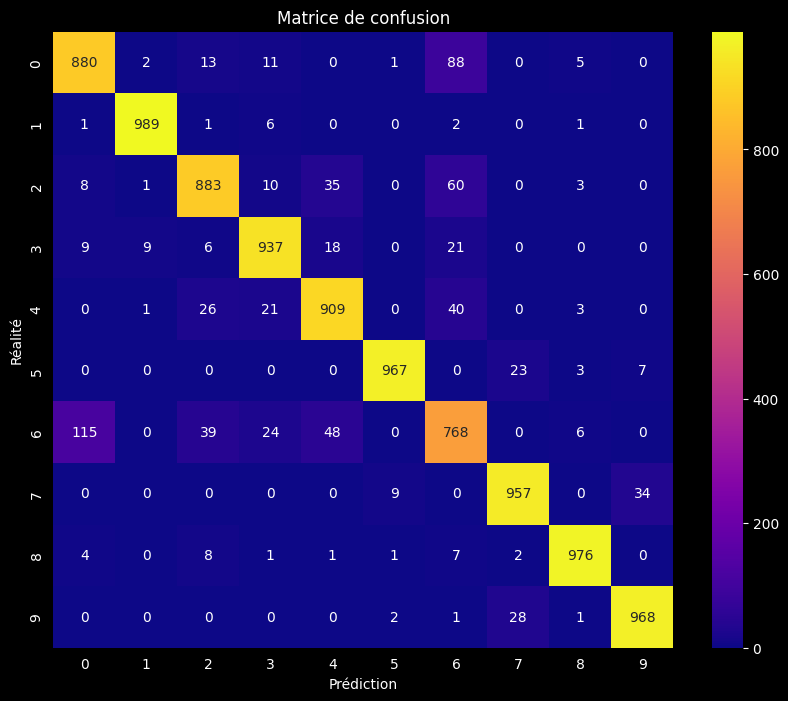

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrice, annot=True, fmt='d', cmap='plasma',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.show()